## Implementation of a denoising convnnet autoencoder using TensorFlow and Keras
### Tuan Le
### tuanle@hotmail.de

For this notebook the MNIST dataset will be used again. As stated in [the neural net autoencoder notebook](https://github.com/ptl93/DeepLearning_AutoEncoders/blob/master/NeuralNetwork_AutoEncoder.ipynb)
an autoencoder has the purpose to first shrink the dimension of feature space of the original $\mathbf{X}$ data into latent space.
This part as encoding has for example the aim to better learn our target $\mathbf{y}$, since in latent space (even with lower) dimension the neural net can better learn the structure in latent space rather than in the original feature space.  
Once the encoding part is done, we want to reconstruct our original image. Note that with the decoder we practically gained a generator for the feature (input) data. Thus if we were to sample new observation in the latent space, with applying the decoder over the sampled data we would have generated new images. Another application of the autoencoder can be anomaly detection as stated in the following [paper](https://arxiv.org/abs/1802.00187).  
  
With the denoising autoencoder as input we will feed the model with noisy data but the target to be learned is the uncorrupted data. With this the model is forced to learn the noising in the 'real' world and for new observations predict the state or rather image without noise.  
For the architecture of the convnet autoencoder I will use the same as in the other [notebook provided](https://github.com/ptl93/DeepLearning_AutoEncoders/blob/master/Convolutional_NN_AutoEncoder.ipynb) except we use RMSprop algorithm, a batch-size of 128 and 20 epochs (due to the running time).

In [1]:
### Load libraries and modules ###
import numpy as np
from keras.datasets import mnist
(x_train, _), (x_test, _) = mnist.load_data()

C:\Users\tuanl\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


11493376/11490434 [==============================] - 8s 1us/step


In [2]:
### Preprocess
# Scale into range (0,1)
x_train = x_train.astype('float32') / np.max(x_train)
x_test = x_test.astype('float32') / np.max(x_test)
print("Shape of x_train: {}".format(x_train.shape))
print("Shape of x_test: {}".format(x_test.shape))
# For convolutional add third (rgb) dimension
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)) 
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])

Shape of x_train: (60000, 28, 28)
Shape of x_test: (10000, 28, 28)


In [3]:
### Add noise to the data. Note the images are already scaled to (0,1). Hence we use a standatd normal distribution to sample the noise
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

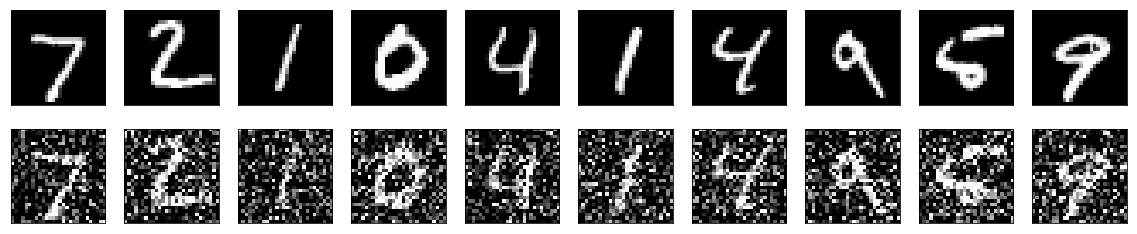

In [4]:
### Plot the noisy images
import matplotlib.pyplot as plt
%matplotlib inline

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, 10 , i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, 10 , i + n + 1)
    # display noisy 
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [5]:
### Model builder
def conv_autoencoder(input_shape):
    ## Import keras modules for defining architecture## 
    from keras.models import Sequential
    from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, UpSampling2D
    
    model = Sequential()
    
    ##### Encoder Part #####
    #### 1. Convolutional Layer with relu####
    model.add(Conv2D(32, (3, 3),
                                padding='same', input_shape=input_shape,
                                activation='relu', name='enc_conv_layer_1_relu'))
    
    ## Add BatchNormalization
    model.add(BatchNormalization(name='enc_batch_normal_layer_1'))
    ## Add MaxPooling to shrink dimension
    model.add(MaxPooling2D((2,2), padding='same', name='enc_max_pooling_layer_1'))
    
    #### 2. Covolutional Layer with kernel initializer and lecun_normal activation ####
    model.add(Conv2D(16, (3, 3),
                                activation='selu', padding='same',
                                kernel_initializer='lecun_normal', name='enc_conv_layer_2_selu'))
    ## Add Maxpooling to shrink dimension
    model.add(MaxPooling2D((2,2), padding='same', name='enc_max_pooling_layer_2'))
    
    #### 3. Convolutional Layer with kernel initializer and softplus activation ####
    model.add(Conv2D(8, (3, 3),
                                activation='softplus', padding='same',
                                kernel_initializer='RandomNormal', name='enc_conv_layer_3_softplus'))
    
    model.add(BatchNormalization(name='enc_batch_normal_layer_3'))
    ## Add Maxpooling as last dimension shrinkage for the encoder part
    model.add(MaxPooling2D((2, 2), padding='same', name='max_pooling_layer_3'))
    
    ##### Decoder Part #####
    #### 4. Convolutional Layer with relu activation ####
    model.add(Conv2D(8, (3, 3),
                                activation='relu', padding='same',
                                kernel_initializer='lecun_normal', name='dec_conv_layer_4_relu'))
    model.add(BatchNormalization(name='dec_batch_normal_layer_4'))
    #### Add deconvolution or rather transposed convolution
    model.add(UpSampling2D((2, 2), name='dec_upsample_conv_layer4'))
    
    #### 5. Convolutional Layer with relu activation ####
    model.add(Conv2D(16, (3, 3),
                                activation='relu', padding='same',
                                kernel_initializer='lecun_normal', name='dec_conv_layer_5_relu'))
    model.add(BatchNormalization(name='dec_batch_normal_layer_5'))
    #### Add deconvolution or rather transposed convolution
    model.add(UpSampling2D((2, 2), name='dec_upsample_conv_layer5'))
    
    #### 6. Convolutional Layer with relu activation ####
    model.add(Conv2D(32, (3, 3),
                                activation='relu', padding='valid',
                                kernel_initializer='lecun_normal', name='dec_conv_layer_6_relu'))
    model.add(BatchNormalization(name='dec_batch_normal_layer_6'))
    #### Add deconvolution or rather transposed convolution
    model.add(UpSampling2D((2, 2), name='dec_upsample_conv_layer6'))
    
    #### 7. Convolutional Layer with relu activation as decoder part, hence number of filters only 1####
    model.add(Conv2D(1, (3, 3),
                                activation='sigmoid', padding='same',
                                kernel_initializer='lecun_normal', name='dec_conv_layer_7_relu'))
    
    return model

In [6]:
### Build the model
conv_autoencoder = conv_autoencoder(input_shape=input_shape)
print(conv_autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
enc_conv_layer_1_relu (Conv2 (None, 28, 28, 32)        320       
_________________________________________________________________
enc_batch_normal_layer_1 (Ba (None, 28, 28, 32)        128       
_________________________________________________________________
enc_max_pooling_layer_1 (Max (None, 14, 14, 32)        0         
_________________________________________________________________
enc_conv_layer_2_selu (Conv2 (None, 14, 14, 16)        4624      
_________________________________________________________________
enc_max_pooling_layer_2 (Max (None, 7, 7, 16)          0         
_________________________________________________________________
enc_conv_layer_3_softplus (C (None, 7, 7, 8)           1160      
_________________________________________________________________
enc_batch_normal_layer_3 (Ba (None, 7, 7, 8)           32        
__________

In [7]:
### Train: 
from keras.losses import binary_crossentropy
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint

conv_autoencoder.compile(
            loss = binary_crossentropy,
            optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0),
            metrics = ['accuracy']
        )
callbacks = [
            ModelCheckpoint(filepath = 'cnn_autencoder_denoising.hdf5', monitor = 'val_acc',
                save_best_only = True, verbose=1, mode = 'max')
            ]

import datetime
start_train = datetime.datetime.now()
history = conv_autoencoder.fit(
            x=x_train_noisy, y=x_train,
            epochs=20,
            batch_size=128,
            shuffle=True,
            validation_data=(x_test_noisy, x_test),
            callbacks = callbacks
        )
end_train = datetime.datetime.now()
time_train = end_train - start_train
print("Training took:", time_train)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 19s 318us/step - loss: 0.2256 - acc: 0.7836 - val_loss: 0.1704 - val_acc: 0.7971

Epoch 00001: val_acc improved from -inf to 0.79707, saving model to cnn_autencoder_denoising.hdf5
Epoch 2/20
60000/60000 [==============================] - 16s 259us/step - loss: 0.1467 - acc: 0.8052 - val_loss: 0.1582 - val_acc: 0.7933

Epoch 00002: val_acc did not improve from 0.79707
Epoch 3/20
60000/60000 [==============================] - 16s 259us/step - loss: 0.1375 - acc: 0.8069 - val_loss: 0.1324 - val_acc: 0.8069

Epoch 00003: val_acc improved from 0.79707 to 0.80689, saving model to cnn_autencoder_denoising.hdf5
Epoch 4/20
60000/60000 [==============================] - 16s 260us/step - loss: 0.1324 - acc: 0.8078 - val_loss: 0.1310 - val_acc: 0.8048

Epoch 00004: val_acc did not improve from 0.80689
Epoch 5/20
60000/60000 [==============================] - 16s 263us/step - loss: 0.1289 - a

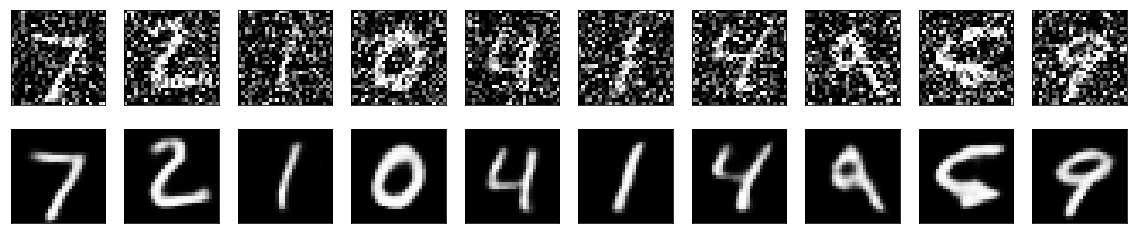

In [8]:
### Apply the autoencoder and predict the unnoised images
decoded_imgs = conv_autoencoder.predict(x_test_noisy)

import matplotlib.pyplot as plt
%matplotlib inline

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display noisy images
    ax = plt.subplot(2, 10 , i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, 10 , i + n + 1)
    # display denoised images 
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Compare the denoised images with the original images:

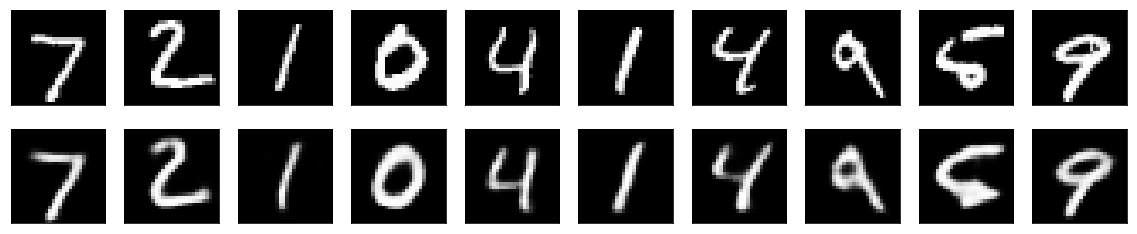

In [9]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display noisy images
    ax = plt.subplot(2, 10 , i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, 10 , i + n + 1)
    # display denoised images 
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

As can be seen it is still a little burry, but the reconstruction is ok. Probably the blurryness comes because of the strong noise enhances by the addition of $\mathcal{N}(0,1) * 0.75$ noise. By that we added 75% standard gaussian noise which is pretty much for a single pixel value being between 0 and 1. 

In [10]:
## END ##